In [1]:
%matplotlib inline

In [2]:
import os
DATA_PATH = '.'
HOSTNAME = !hostname
if HOSTNAME[0] == 'z-deepbox':
    DATA_PATH = os.path.join(os.path.expanduser('~'), 'data', 'SVHN')

In [3]:
from torchvision import transforms as T
import numpy as np
import PIL
from PIL import Image

# Define transformations
class PILTransform:
    def __init__(self, fn, min_value=None, max_value=None, cast_type=None):
        self.fn = fn
        self.min_value = min_value
        self.rng = None
        if max_value is not None and min_value is not None:
            self.rng = max_value - min_value
        self.cast_type = cast_type

    def __call__(self, img):
        return self.fn(img)

train_transform = T.Compose([
  PILTransform(PIL.ImageOps.autocontrast),
  T.ToTensor()
])

test_transform = T.Compose([
  PILTransform(PIL.ImageOps.autocontrast),
  T.ToTensor()
])

def from_tensor(img_tensor):
    img = img_tensor.detach().cpu().numpy()
    img = img.transpose(1, 2, 0)
    return np.ascontiguousarray(img)

In [4]:
# Load the dataset
from torchvision.datasets import SVHN

train_set = SVHN(root=DATA_PATH, split='train', transform=train_transform, download=True)
test_set = SVHN(root=DATA_PATH, split='test', transform=test_transform, download=True)

Using downloaded and verified file: /home/zafar/data/SVHN/train_32x32.mat
Using downloaded and verified file: /home/zafar/data/SVHN/test_32x32.mat


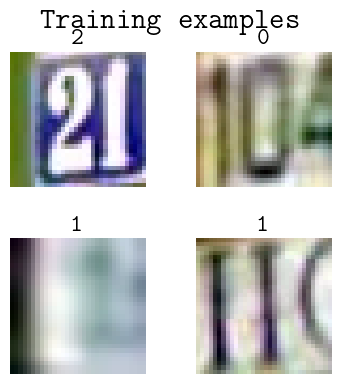

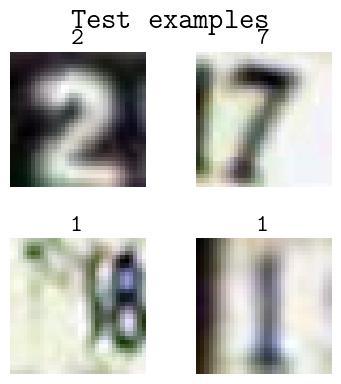

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)
for a in ax.flat:
    idx = np.random.randint(len(train_set))
    img = from_tensor(train_set[idx][0])
    a.imshow(img)
    a.axis('off')
    a.set_title(f'{train_set[idx][1]}')
plt.suptitle('Training examples')
plt.tight_layout()

fig, ax = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)
for a in ax.flat:
    idx = np.random.randint(len(test_set))
    img = from_tensor(test_set[idx][0])
    a.imshow(img)
    a.axis('off')
    a.set_title(f'{test_set[idx][1]}')
plt.suptitle('Test examples')
plt.tight_layout()

In [6]:
# Make model

import torch
from torch import nn
from torch.nn import functional as F

from torchsummary import summary

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x, *args):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class ManningModel(nn.Module):
    def __init__(self):
        super(ManningModel, self).__init__()
        self.block1 = Block(3, 6, 5, stride=1, padding=2)
        self.block2 = Block(6, 12, 3, stride=1, padding=1)
        self.block3 = Block(12, 24, 3, stride=1, padding=1)
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(96, 10)

    def forward(self, x, *args):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

manning_model = ManningModel()
summary(manning_model, (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              ReLU-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
             Block-5            [-1, 6, 14, 14]               0
            Conv2d-6           [-1, 12, 12, 12]             660
       BatchNorm2d-7           [-1, 12, 12, 12]              24
              ReLU-8           [-1, 12, 12, 12]               0
         MaxPool2d-9             [-1, 12, 6, 6]               0
            Block-10             [-1, 12, 6, 6]               0
           Conv2d-11             [-1, 24, 4, 4]           2,616
      BatchNorm2d-12             [-1, 24, 4, 4]              48
             ReLU-13             [-1, 24, 4, 4]               0
        MaxPool2d-14             [-1, 2

(tensor(4786), tensor(4786))

In [7]:
import torch

def compute_correct(outputs, y):
    _, y_hat = torch.max(outputs.data, 1)
    return (y_hat == y).sum().item()

def get_accuracy(model, dataloader, device='cpu'):
    was_training_before = model.training
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            correct += compute_correct(outputs, y)
            total += y.size(0)
    model.training = was_training_before
    return correct / total

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader

PRINT_EVERY = 10

TRAIN_BATCH_SIZE = 2048
TEST_BATCH_SIZE = 2048

loader = {
    'train': DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE,
                                            pin_memory=True, num_workers=os.cpu_count()),
    'eval': DataLoader(test_set, batch_size=TEST_BATCH_SIZE,
                                         pin_memory=True, num_workers=os.cpu_count())
}

DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'
EPOCHS = 30

manning_model = manning_model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(manning_model.parameters(), lr=0.001)

history = {
    'epochs': [],
    'train': {
        'loss': [],
        'accuracy': []
    },
    'eval': {
        'loss': [],
        'accuracy': []  
    }
}

for epoch in range(EPOCHS):
    history['epochs'].append(epoch)
    for mode in ['train', 'eval']:
        is_training = (mode == 'train')
        torch.set_grad_enabled(is_training)
        manning_model.training = is_training
        manning_model.requires_grad = is_training

        total = 0
        running_loss = 0.0
        running_correct = 0.0

        for idx, data in enumerate(loader[mode], 0):
            x_data, y_data = data
            x_data = x_data.to(DEVICE)
            y_data = y_data.to(DEVICE)

            optimizer.zero_grad()
            y_hat = manning_model(x_data)
            loss = criterion(y_hat, y_data)

            if is_training:
                loss.backward()
                optimizer.step()

            total += y_data.size(0)
            running_loss += loss.item()
            running_correct += compute_correct(y_hat, y_data)

            if (idx + 1) % PRINT_EVERY == 0:
                print(f'{" ": >5s}::{epoch+1}/{EPOCHS} [{idx+1}] LOSS: {running_loss / total:.2e}, ACCURACY: {running_correct / total:.2%}')
        epoch_loss = running_loss / total
        epoch_accuracy = running_correct / total
        history[mode]['loss'].append(epoch_loss)
        history[mode]['accuracy'].append(epoch_accuracy)
        print(f'{mode: >5s}::{epoch+1}/{EPOCHS} [**] LOSS: {epoch_loss:.2e}, ACCURACY: {epoch_accuracy:.2%}')
    print()

     ::1/30 [10] LOSS: 1.09e-03, ACCURACY: 18.81%
     ::1/30 [20] LOSS: 1.02e-03, ACCURACY: 25.59%
     ::1/30 [30] LOSS: 9.67e-04, ACCURACY: 31.31%
train::1/30 [**] LOSS: 9.41e-04, ACCURACY: 34.32%
     ::1/30 [10] LOSS: 7.29e-04, ACCURACY: 54.87%
 eval::1/30 [**] LOSS: 7.45e-04, ACCURACY: 54.95%

     ::2/30 [10] LOSS: 7.07e-04, ACCURACY: 56.04%
     ::2/30 [20] LOSS: 6.74e-04, ACCURACY: 58.30%
     ::2/30 [30] LOSS: 6.43e-04, ACCURACY: 60.57%
train::2/30 [**] LOSS: 6.31e-04, ACCURACY: 61.76%
     ::2/30 [10] LOSS: 5.13e-04, ACCURACY: 71.11%
 eval::2/30 [**] LOSS: 5.24e-04, ACCURACY: 71.09%

     ::3/30 [10] LOSS: 5.06e-04, ACCURACY: 70.63%
     ::3/30 [20] LOSS: 4.90e-04, ACCURACY: 71.36%
     ::3/30 [30] LOSS: 4.74e-04, ACCURACY: 72.35%
train::3/30 [**] LOSS: 4.69e-04, ACCURACY: 72.94%
     ::3/30 [10] LOSS: 4.04e-04, ACCURACY: 77.14%
 eval::3/30 [**] LOSS: 4.12e-04, ACCURACY: 77.17%

     ::4/30 [10] LOSS: 4.00e-04, ACCURACY: 77.18%
     ::4/30 [20] LOSS: 3.93e-04, ACCURACY: 77.5

     ::28/30 [10] LOSS: 1.69e-04, ACCURACY: 90.06%
     ::28/30 [20] LOSS: 1.70e-04, ACCURACY: 89.90%
     ::28/30 [30] LOSS: 1.71e-04, ACCURACY: 89.79%
train::28/30 [**] LOSS: 1.71e-04, ACCURACY: 89.80%
     ::28/30 [10] LOSS: 1.99e-04, ACCURACY: 88.09%
 eval::28/30 [**] LOSS: 2.01e-04, ACCURACY: 88.17%

     ::29/30 [10] LOSS: 1.68e-04, ACCURACY: 90.13%
     ::29/30 [20] LOSS: 1.68e-04, ACCURACY: 89.96%
     ::29/30 [30] LOSS: 1.69e-04, ACCURACY: 89.86%
train::29/30 [**] LOSS: 1.70e-04, ACCURACY: 89.87%
     ::29/30 [10] LOSS: 1.98e-04, ACCURACY: 88.17%
 eval::29/30 [**] LOSS: 2.01e-04, ACCURACY: 88.25%

     ::30/30 [10] LOSS: 1.67e-04, ACCURACY: 90.20%
     ::30/30 [20] LOSS: 1.67e-04, ACCURACY: 90.07%
     ::30/30 [30] LOSS: 1.68e-04, ACCURACY: 89.93%
train::30/30 [**] LOSS: 1.69e-04, ACCURACY: 89.95%
     ::30/30 [10] LOSS: 1.97e-04, ACCURACY: 88.24%
 eval::30/30 [**] LOSS: 2.00e-04, ACCURACY: 88.32%



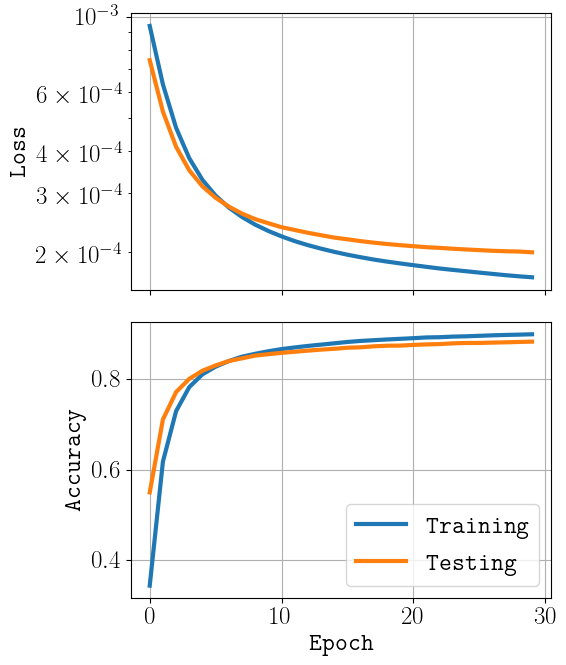

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(6, 7), sharex=True)

ax[0].plot(history['epochs'], history['train']['loss'])
ax[0].plot(history['epochs'], history['eval']['loss'])
ax[0].set_yscale('log')
ax[0].set_ylabel('Loss')
ax[0].grid('both')

ax[1].plot(history['epochs'], history['train']['accuracy'], label='Training')
ax[1].plot(history['epochs'], history['eval']['accuracy'], label='Testing')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].grid('both')
ax[1].legend()

plt.tight_layout()

### Custom Dataset

I would still not use custom dataset, as it prevents a lot of transformations to be used from the PIL library

In [10]:
from torch.utils.data import Dataset
from scipy.io import loadmat

class SVHN_dataset(Dataset):
    def __init__(self, matlab_data_path):
        # Transform data to Torch Tensors
        data = loadmat(matlab_data_path)
        self.images = torch.tensor(data['X']).permute([3, 2, 0, 1]).contiguous()
        self.labels = torch.tensor(data['y'])
        self.size = self.labels.shape[0]

        # replace label 10 with label 0
        mask = (self.labels == 10)
        self.labels[mask] = 0

        # convert to float and normalize images to 0..1 range
        self.images = self.images.to(torch.float) / 255.0

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
    
test_dataset = SVHN_dataset(os.path.join(DATA_PATH, 'test_32x32.mat'))

## Different Model

In [11]:
class RandomTransform(PILTransform):
    def __init__(self, fn, p=0.5, *args, **kwargs):
        super(RandomTransform, self).__init__(fn, *args, **kwargs)
        self.p = p
    def __call__(self, img):
        rand_value = np.random.rand()
        if rand_value <= self.p:
            return self.fn(img)
        return img

class EnhanceTransform(PILTransform):
    def __call__(self, img):
        value = np.random.rand() * self.rng + self.min_value
        if self.cast_type is not None:
            value = self.cast_type(value)
        return self.fn(img).enhance(value)
    
    
train_transform = T.Compose([
    T.RandomAffine(
      degrees=30,
      translate=(0.1, 0.1),
      shear=(10, 10),
      scale=(0.9, 1.1),
      resample = PIL.Image.BILINEAR
    ),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    PILTransform(PIL.ImageOps.autocontrast),
    RandomTransform(PIL.ImageOps.equalize),
    RandomTransform(PIL.ImageOps.invert),
    EnhanceTransform(PIL.ImageEnhance.Contrast, 0.2, 1.5),
    EnhanceTransform(PIL.ImageEnhance.Brightness, 0.2, 1.5),
    EnhanceTransform(PIL.ImageEnhance.Color, 0.2, 1.5),
    EnhanceTransform(PIL.ImageEnhance.Sharpness, 0.2, 1.5),
    T.ToTensor()
])

test_transform = T.Compose([
    PILTransform(PIL.ImageOps.autocontrast),
    T.ToTensor()
])

In [12]:
# Model:
# We will use simplified VGG with the DNA:
#  [64, 128, 'M', 128, 256, 'M', 256, 'M', 256, 'M']

import torch.nn.functional as F

class BlockConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bn=True):
        super(BlockConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        if bn:
            self.bn = nn.BatchNorm2d(out_channels)
        else:
            self.bn = None
        self.relu = nn.ReLU()

    def forward(self, x, *args):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        x = self.relu(x)
        return x
    
class BlockDropout(nn.Module):
    """BlockDropout from https://arxiv.org/abs/1810.12890"""
    def __init__(self, prob, block_size):
        super(BlockDropout, self).__init__()
        self.p = prob
        self.bs = block_size
        self.gamma =  self.p / (self.bs**2)
        
    def forward(self, x):
        if not self.training or self.p == 0:
            return x
        mask = (torch.rand(x.shape[0], *x.shape[2:]) < self.gamma).float()
        mask = mask.to(x.device)
        block_mask = self._block_mask(mask)
        y = x * block_mask[:, None, :, :]
        return y
    
    def _block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.bs, self.bs),
                                  stride=(1, 1),
                                  padding=(self.bs // 2))
        if self.bs % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]
        block_mask = 1 - block_mask.squeeze(1)
        return block_mask

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.block1 = BlockConv(3, 64, 5, padding=2, bn=False)
        self.block2 = BlockConv(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout1 = BlockDropout(0.5, 5)
        
        self.block4 = BlockConv(128, 128, 3, padding=1, bn=False)
        self.block5 = BlockConv(128, 256, 3, padding=1)
        self.pool6 = nn.MaxPool2d(2, 2)
        self.dropout2 = BlockDropout(0.5, 3)
        
        self.block7 = BlockConv(256, 256, 3, padding=1)
        self.pool8 = nn.MaxPool2d(2, 2)
        
        self.block9 = BlockConv(256, 256, 3, padding=1)
        self.pool10 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1024, 128)
        self.relu_linear = nn.ReLU()
        self.dropout_linear = nn.Dropout()
        self.linear2 = nn.Linear(128, 10)
        

    def forward(self, x, *args):
        x = self.block1(x)
        x = self.dropout1(x)
        x = self.block2(x)
        x = self.pool3(x)
        
        x = self.block4(x)
        x = self.dropout2(x)
        x = self.block5(x)
        x = self.pool6(x)
        
        x = self.block7(x)
        x = self.pool8(x)
        
        x = self.block9(x)
        x = self.pool10(x)
        
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu_linear(x)
        x = self.dropout_linear(x)
        x = self.linear2(x)
        return x
    
summary(MyModel(), (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
              ReLU-2           [-1, 64, 32, 32]               0
         BlockConv-3           [-1, 64, 32, 32]               0
      BlockDropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
         BlockConv-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
             ReLU-11          [-1, 128, 16, 16]               0
        BlockConv-12          [-1, 128, 16, 16]               0
     BlockDropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

(tensor(1835914), tensor(1835914))

In [13]:
import torch.optim as optim
from torch.utils.data import DataLoader

PRINT_EVERY = 10

TRAIN_BATCH_SIZE = 2048
TEST_BATCH_SIZE = 2048

loader = {
    'train': DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE,
                        pin_memory=True, num_workers=os.cpu_count()),
    'eval': DataLoader(test_set, batch_size=TEST_BATCH_SIZE,
                       pin_memory=True, num_workers=os.cpu_count())
}

DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'
EPOCHS = 50

my_model = MyModel().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_model.parameters(), lr=0.001)

history = {
  'epochs': [],
  'train': {
    'loss': [],
    'accuracy': []
  },
  'eval': {
    'loss': [],
    'accuracy': []  
  }
}

for epoch in range(EPOCHS):
    history['epochs'].append(epoch)
    for mode in ['train', 'eval']:
        is_training = (mode == 'train')
        torch.set_grad_enabled(is_training)
        my_model.training = is_training
        my_model.requires_grad = is_training

        total = 0
        running_loss = 0.0
        running_correct = 0.0

        for idx, data in enumerate(loader[mode], 0):
            x_data, y_data = data
            x_data = x_data.to(DEVICE)
            y_data = y_data.to(DEVICE)

            optimizer.zero_grad()
            y_hat = my_model(x_data)
            loss = criterion(y_hat, y_data)

            if is_training:
                loss.backward()
                optimizer.step()

            total += y_data.size(0)
            running_loss += loss.item()
            running_correct += compute_correct(y_hat, y_data)

            if (idx + 1) % PRINT_EVERY == 0:
                print(f'{" ": >5s}::{epoch+1}/{EPOCHS} [{idx+1}] LOSS: {running_loss / total:.2e}, ACCURACY: {running_correct / total:.2%}')
        epoch_loss = running_loss / total
        epoch_accuracy = running_correct / total
        history[mode]['loss'].append(epoch_loss)
        history[mode]['accuracy'].append(epoch_accuracy)
        print(f'{mode: >5s}::{epoch+1}/{EPOCHS} [**] LOSS: {epoch_loss:.2e}, ACCURACY: {epoch_accuracy:.2%}')
    print()

     ::1/50 [10] LOSS: 1.13e-03, ACCURACY: 15.58%
     ::1/50 [20] LOSS: 1.11e-03, ACCURACY: 17.03%
     ::1/50 [30] LOSS: 1.10e-03, ACCURACY: 17.69%
train::1/50 [**] LOSS: 1.10e-03, ACCURACY: 18.29%
     ::1/50 [10] LOSS: 1.03e-03, ACCURACY: 23.77%
 eval::1/50 [**] LOSS: 1.05e-03, ACCURACY: 23.86%

     ::2/50 [10] LOSS: 1.02e-03, ACCURACY: 24.30%
     ::2/50 [20] LOSS: 9.96e-04, ACCURACY: 26.40%
     ::2/50 [30] LOSS: 9.67e-04, ACCURACY: 28.79%
train::2/50 [**] LOSS: 9.56e-04, ACCURACY: 30.15%
     ::2/50 [10] LOSS: 8.19e-04, ACCURACY: 41.29%
 eval::2/50 [**] LOSS: 8.40e-04, ACCURACY: 41.16%

     ::3/50 [10] LOSS: 8.03e-04, ACCURACY: 42.29%
     ::3/50 [20] LOSS: 7.68e-04, ACCURACY: 44.93%
     ::3/50 [30] LOSS: 7.31e-04, ACCURACY: 47.32%
train::3/50 [**] LOSS: 7.17e-04, ACCURACY: 48.45%
     ::3/50 [10] LOSS: 6.05e-04, ACCURACY: 56.15%
 eval::3/50 [**] LOSS: 6.17e-04, ACCURACY: 56.11%

     ::4/50 [10] LOSS: 5.87e-04, ACCURACY: 57.22%
     ::4/50 [20] LOSS: 5.69e-04, ACCURACY: 58.7

     ::28/50 [10] LOSS: 1.51e-04, ACCURACY: 89.97%
     ::28/50 [20] LOSS: 1.53e-04, ACCURACY: 89.88%
     ::28/50 [30] LOSS: 1.54e-04, ACCURACY: 89.83%
train::28/50 [**] LOSS: 1.55e-04, ACCURACY: 89.92%
     ::28/50 [10] LOSS: 2.10e-04, ACCURACY: 87.70%
 eval::28/50 [**] LOSS: 2.13e-04, ACCURACY: 87.65%

     ::29/50 [10] LOSS: 1.53e-04, ACCURACY: 89.93%
     ::29/50 [20] LOSS: 1.54e-04, ACCURACY: 89.85%
     ::29/50 [30] LOSS: 1.53e-04, ACCURACY: 89.97%
train::29/50 [**] LOSS: 1.53e-04, ACCURACY: 90.01%
     ::29/50 [10] LOSS: 2.06e-04, ACCURACY: 87.67%
 eval::29/50 [**] LOSS: 2.12e-04, ACCURACY: 87.67%

     ::30/50 [10] LOSS: 1.50e-04, ACCURACY: 90.36%
     ::30/50 [20] LOSS: 1.48e-04, ACCURACY: 90.32%
     ::30/50 [30] LOSS: 1.49e-04, ACCURACY: 90.26%
train::30/50 [**] LOSS: 1.49e-04, ACCURACY: 90.26%
     ::30/50 [10] LOSS: 2.13e-04, ACCURACY: 87.64%
 eval::30/50 [**] LOSS: 2.15e-04, ACCURACY: 87.73%

     ::31/50 [10] LOSS: 1.48e-04, ACCURACY: 90.20%
     ::31/50 [20] LOSS: 1.45

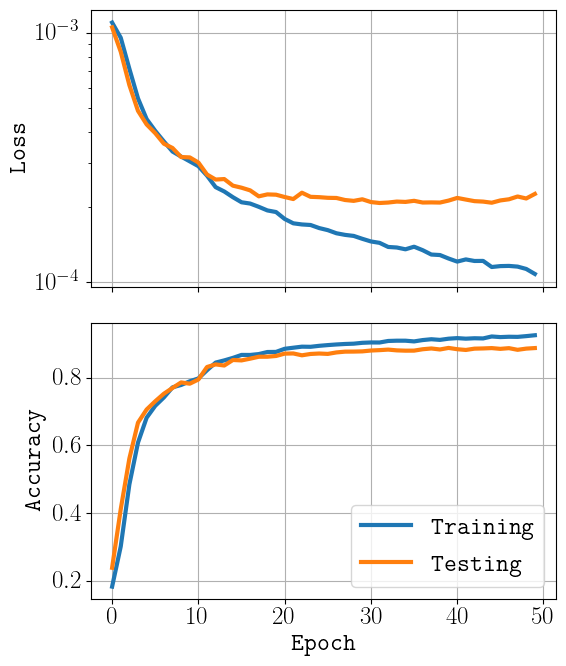

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(6, 7), sharex=True)

ax[0].plot(history['epochs'], history['train']['loss'])
ax[0].plot(history['epochs'], history['eval']['loss'])
ax[0].set_yscale('log')
ax[0].set_ylabel('Loss')
ax[0].grid('both')

ax[1].plot(history['epochs'], history['train']['accuracy'], label='Training')
ax[1].plot(history['epochs'], history['eval']['accuracy'], label='Testing')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].grid('both')
ax[1].legend()

plt.tight_layout()

Overfitting LIKE CRAZY! Need more regularization... :/